In [66]:
# import pip

In [67]:
# pip.main(["install", "openpyxl"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


0

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#path = Path.cwd().joinpath("Raw_sensing_data","CO","Cu-COF-DC-8","N2_dry").rglob("*.xlsx")

#for i in path:
#    print(i)

In [3]:
def read_data(cof, gas, carrier, ppm):

    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data",gas,cof,carrier,).rglob("*.xlsx")
    #print(path)
    # some folders contain multiple excel files, so append all to a list
    files = []
    for file in path:
        files.append(file)
    print(files)
    # extract data from Excel files in list
    dfs = []
    for p in files:
        df = pd.read_excel(p,header=6,names=['time','DeltaG/G0'],usecols="B,D")
       
        df = df.dropna()
        dfs.append(df)
        
        
    return dfs
# returns pandas data frame with this data. two columns: time, DeltaG/G0

In [35]:
#print(read_data("Cu-COF-DC-8","CO","N2_dry",80))

data = read_data("Cu-COF-DC-8","H2S","air_humid",80)

[WindowsPath('c:/github things/cof-sensor-array-v2/Raw_sensing_data/H2S/Cu-COF-DC-8/air_humid/GB_S_I_188_2_Cu-COF-DC-8_H2S_80ppm_humidair.xlsx')]


        time  DeltaG/G0
1497   749.0  -0.054345
1498   749.5   0.000000
1499   750.0   0.000000
1500   750.5   0.000000
1501   751.0  -0.217382
...      ...        ...
1996   998.5  79.549610
1997   999.0  79.560375
1998   999.5  79.647189
1999  1000.0  79.658127
2000  1000.5  79.582252

[504 rows x 2 columns]
1497    0.032607
1498    0.043476
1499    0.043476
1500    0.043476
1501    0.000000
          ...   
1566    0.238773
1567    0.303848
1568    0.347221
1569    0.325552
1570    0.325552
Length: 74, dtype: float64
0.34722065475001884 1568
749.0 785.5


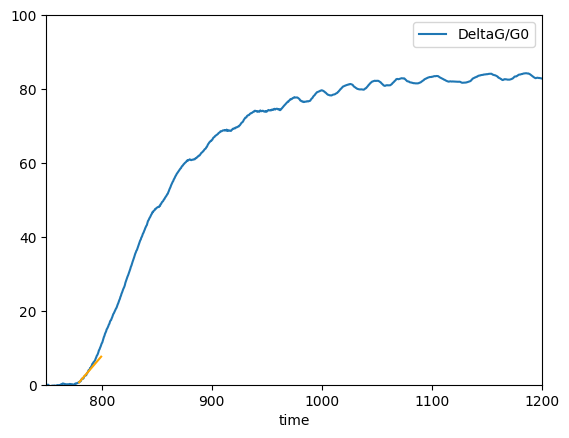

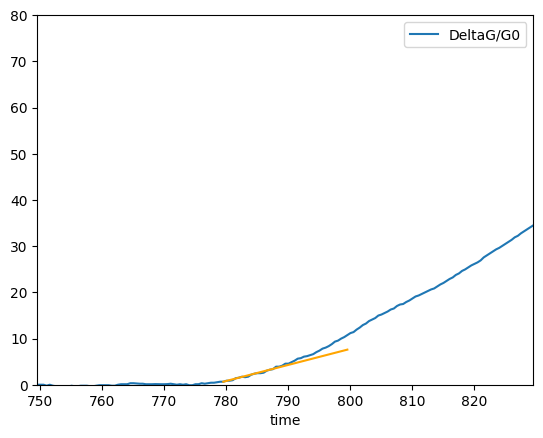

In [78]:
print(data[0].loc[1497:2000])
axes = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,1200),ylim=(0,100))


init_t = 1497
init_t_end = 1570
per = 10
slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]
#slopes = data[0].diff().loc[1400:1600,"DeltaG/G0"] / 0.5

print(slopes)
maxslope = slopes.max()
maxloc = slopes.idxmax()
print(maxslope,maxloc)
print(data[0].loc[init_t,"time"],data[0].loc[init_t_end,"time"])

x = [data[0].loc[maxloc-per,"time"],data[0].loc[maxloc+40-per,"time"]]
y = [data[0].loc[maxloc-per,"DeltaG/G0"],(x[1]-x[0])*maxslope + data[0].loc[maxloc-per,"DeltaG/G0"]]

axes.plot(x,y,'orange')

axes2 = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,829.5),ylim=(0,80))
axes2.plot(x,y,'orange')

In [72]:
class SensorResponse:
    def _init_(self, cof, gas, carrier_gas, ppm):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm

        self.data = read_data(cof,gas,carrier_gas,ppm)
        
     # read in the data, do processing to get the features.
     # store data here too for viz
        


    def compute_initial_slope(self, nb_pts):
        initial_slopes = []
        init_t = 1497
        init_t_end = 1570
        per = 10
        for df in data:
            # initialize slopes of change in DeltaG/G0 / change in time
            # restrict to time locations between 749 seconds and 800.5 seconds
            slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]

            # find maximum slope 
            maxslope = slopes.max()
            maxloc = slopes.idxmax()

            # add initial slope to list of initial slopes
            initial_slopes.append(maxslope)

        return initial_slopes
   #def compute_saturation(self):
   #def compute_area(self):
   #def viz(self, save=False): # viz the data along with the response features or function u fit to it.
   #def vector_representation(self): # returns the vector characterizing the response.